# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
###Garrett Eickelberg with help from Kishore Anekalla, Yikuan Li, Dr. Yuan Luo, Dr. Nelson Sanchez-Pinto

the streamlined version of "rotation_cohort_generation" has lots of debugging, older code, and non-utilized code removed to allow for top to bottom running. 

the overarching contents of this notebook will be detailed in my googledoc labnotebook 
https://docs.google.com/document/d/1bJcv0ZUkjVhFga9ZOLMNV6pXR9jLEMQmPhLS93njrCc/edit#

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random
from datetime import timedelta

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#reserach question:
-Can we predict the 5/7 day ab course by 48 hours after culture/ab start for icu patients?

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window (bulk will be in first 24 hours but possibly not). 


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

In [2]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 2.36 s


# importing prescription table annotated with RXCUI and ATC codes to id AB

In [3]:
#this code takes a while to run, only run if need to update prescription table (which is saved in github)
# #some rows in AB have the same drug name, but differing true/false ab status. this is updating any antibiotic row as true.

# #input: imported prescription df annotated with atc codes. 
# #ouput: updated prescription df where more true antibiotics are covered

# @memory.cache
# def prescription_update_fxn(prescription_df):
#         drugs_that_dont_belong =['Furosemide','Dextrose 50%','Vancomycin Oral Liquid',
#                          'Erythromycin 0.5% Ophth Oint','NEO*IV*Furosemide',
#                          'Nystatin','Orthopedic Solution','Neomycin-Polymyxin-Bacitracin Ophth. Oint',
#                          'Bacitracin Ophthalmic Oint','Bacitracin Ointment','Lasix',
#                          'dextrose','MetronidAZOLE Topical 1 % Gel','Enalaprilat',
#                          'NEO*PO*Furosemide (10mg/1ml)','Metronidazole Gel 0.75%-Vaginal','Spironolactone',
#                          'Heparin',
#                         'voriconazole','valgancyclovir','chloroquine','tamiflu','mefloquine','foscarnet',
#                          'fluconazole','vorconazole','quinine','ribavirin','gancyclovir','chloroquine',
#                          'atovaquone','ambisome', 'acyclovir', 'Acyclovir']

#     drugs_that_dont_belong=[w.lower() for w in drugs_that_dont_belong]
    
#     prescriptions= prescription_df
#     prescriptions_updated = list(prescriptions.loc[prescriptions.loc[:,"Antibiotics"]==True,'drug'].unique()) 
#     true_ndc= prescriptions.loc[prescriptions.loc[:,"drug"].isin(prescriptions_updated),'ndc'].unique() 

#     ABrx2= prescriptions.loc[prescriptions.loc[:,"ndc"].isin(true_ndc),:]
#     ABrx2= ABrx2.loc[~ABrx2.loc[:,"drug"].str.lower().isin(drugs_that_dont_belong),:] #tilde transforms isin to notin()
#     ABrx2['Antibiotics']= True
#     return(ABrx2)



time: 4.3 ms


In [4]:
#this code takes a while to run, only run if need to update prescription table (which is saved in github)
# #note shown: imported antibiotic annotations into prescription table using code provided by
# #Dr. Luo's postdoc, which pings API
# dtype = {'icustay_id': str,
#          'NDC': str,
#          'rxcui': str,
#          'ingredient': str}
# prescriptions = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/project/Newprescription.csv', index_col=0, dtype=dtype)

# #problem: some rows in AB have the same drug name, but differing true/false ab status. this is updating any antibiotic row as true.


# ABrx = prescription_update_fxn(prescriptions)
# ABrx = ABrx.loc[ABrx['Antibiotics'] == True, :]
# pd.DataFrame(ABrx).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')


time: 1.98 ms


In [5]:
ABrx = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')



time: 873 ms


In [6]:
#adjusting the antibiotic start time.
#antibiotics listed in the ABrx table have date but not time resolution for starting. given that 00:00:00 is not a likely starttime for antibiotics, 
#we are chainging the ABrx start time to be on XX:XX:XX for every date. 

time: 645 µs


In [7]:
len(ABrx) #156598
ABrx['drug'].unique()

array(['Daptomycin', 'Ceftazidime', 'Vancomycin HCl',
       'Sulfameth/Trimethoprim SS', 'NEO*IV*Gentamicin', 'Cefepime',
       'Gentamicin Sulfate', 'Vancomycin', 'Levofloxacin',
       'Bacitracin/Polymyxin B Sulfate Opht. Oint', 'CefTRIAXone',
       'Sulfameth/Trimethoprim DS', 'Ciprofloxacin HCl', 'Metronidazole',
       'Azithromycin ', 'Cefazolin', 'Ceftriaxone', 'Imipenem-Cilastatin',
       'CeftazIDIME', 'CeftriaXONE', 'Clindamycin',
       'Piperacillin-Tazobactam Na', 'Ampicillin Sodium', 'CefazoLIN',
       'Cephalexin', 'Linezolid', 'Ampicillin', 'Ciprofloxacin IV',
       'MetRONIDAZOLE (FLagyl)', 'Nystatin Oral Susp.',
       'Nystatin Oral Suspension', 'Amoxicillin-Clavulanic Acid',
       'Ciprofloxacin 0.3% Ophth Soln', 'Unasyn',
       'Gentamicin Sulfate Ophth.', 'NEO*IV*AMPicillin Sodium',
       'NEO*IV*Ampicillin Sodium', 'Gentamicin', 'Azithromycin',
       'Aztreonam', 'Meropenem', 'NEO*IV*Vancomycin', 'Ciprofloxacin',
       'CefePIME', 'Piperacillin-Tazoba

time: 13.5 ms


# generating patient culture/icu/hospital info


## sterile culture info

In [8]:
#retrieving all patients with sterile culture

##changed on 4/16/18 to include all hadm_id
sterile_pt_sql = query_schema + """
SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name FROM mimiciii.microbiologyevents
WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
NOT lower(spec_type_desc) = 'blood bag fluid'
AND (lower(spec_type_desc) LIKE '%blood%' 
OR lower(spec_type_desc) LIKE '%joint%' 
OR lower(spec_type_desc) LIKE '%urine%' 
OR lower(spec_type_desc) LIKE  '%csf%'
OR lower(spec_type_desc) LIKE '%spinal%'
OR lower(spec_type_desc) LIKE '%pleural%'
OR lower(spec_type_desc) LIKE '%peritoneal%'
OR lower(spec_type_desc) LIKE '%bal%'
OR lower(spec_type_desc) LIKE '%bronchoalveolar lavage%')  --bal and bronchoalveolar lavage added 7/16/18

group by subject_id, row_id
ORDER BY count(subject_id) DESC
"""

sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #361711 patients with sterile culture -> 374643 with addn of bal and broncho... 7/16/18


time: 27 s


In [9]:
#a more detailed patient/admission/age data query

pt_age_admin_sql = query_schema + """
select p.subject_id, c.hadm_id, c.admittime, c.dischtime, c.admission_location, c.admission_type, p.first_admit_age, p.dob, p.gender from mimiciii.admissions c
join (SELECT
      p.subject_id, p.dob, p.gender, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id) p on c.subject_id = p.subject_id
"""
pt_age_admin_df = pd.read_sql_query(pt_age_admin_sql,conn) #38637
pt_age_admin_16_df= pt_age_admin_df.loc[pt_age_admin_df.loc[:,'first_admit_age']>16,:]
pt_age_admin_16_df = pt_age_admin_16_df.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

pt_source_sql = query_schema + """
SELECT subject_id, icustay_id, hadm_id, dbsource, intime, outtime, los, FIRST_WARDID, LAST_WARDID from mimiciii.icustays
"""
pt_source_df =pd.read_sql_query(pt_source_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_source_df = pt_source_df.rename(index=str, columns={"intime":'ICU_admit','outtime':'ICU_disch'})

#merging icu info with patient admiin info- has all icustay id's with patient and admission info.
pt_icu_hosp_db_16 =pd.merge(pt_age_admin_16_df,pt_source_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'right')
# len(pt_source_df) #61532
# len(pt_age_admin_16_df)#50857
# len(pt_icu_hosp_db_16) #61532



time: 4.58 s


### mergeing sterile_pt_df with pt_icu_hosp_db_16
   - sterile_all_pt_info:
    is all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

In [10]:
#merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

sterile_all_pt_info= None
#filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.
sterile_all_pt_info = pd.merge(
    pt_icu_hosp_db_16, sterile_pt_df.drop(['subject_id'], axis=1), 
    left_on= 'hadm_id', 
    right_on='hadm_id', 
    how = 'inner'
)

#making all sterile culture charttime null rows = to chartdate. 
sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'charttime'
                       ] = sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'chartdate']

#removing all null admit ages.
sterile_all_pt_info=sterile_all_pt_info[sterile_all_pt_info['first_admit_age'].notnull()] 

sterile_all_pt_info=sterile_all_pt_info.rename(
    index=str, columns={'charttime':'culture_charttime'}) #changing some column names for clarity 


time: 836 ms


In [11]:
#07/13/18
len(sterile_all_pt_info) #424493 rows
len(sterile_all_pt_info['hadm_id'].unique()) #34915 
len(sterile_all_pt_info['icustay_id'].unique())# 38292

###History:
#previously we wanted to only include sterile cultures taken within icu, but we changed our mind on that. 
#ptinfo_ICUsterile_16 was origionally just in ICU, while sterile_all_pt_info was in and outside icu.
#i have sense removed this and adjusted all instances to be sterile_all_pt_info. the code to make this past sheet is below:

#removed below lines because we want to include sterile cultures outside of ICU. 
#annotates the sterile cultures and returns True if it's within the icu time window.
##sterile_all_pt_info['sterile_dur_icu']= (sterile_all_pt_info['ICU_disch'] >= sterile_all_pt_info['charttime']) &(sterile_all_pt_info['charttime']>=sterile_all_pt_info['ICU_admit'])
#sterile_all_pt_info_icu= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'sterile_dur_icu']==True,:]

38395

time: 21.8 ms


# building patient list from PRESCRIPTION table

In [12]:
sterile_all_pt_info_pt= sterile_all_pt_info.drop_duplicates('icustay_id')#38292 on 07-13-18
ABrx_ntnull= ABrx.loc[ABrx.loc[:,"icustay_id"].notnull(),:] #removing null icustay_id
ABrx_16sterile_ntnul = None

#have to convert icustay_id's to numbers to merge
sterile_all_pt_info_pt['icustay_id']= pd.to_numeric(sterile_all_pt_info_pt['icustay_id'])
ABrx_ntnull['icustay_id']= pd.to_numeric(ABrx_ntnull['icustay_id'])

#merging antibiotics table w/ all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture. 
ABrx_16sterile_ntnul= pd.merge(
    ABrx_ntnull,
    sterile_all_pt_info_pt.drop(['subject_id','hadm_id','row_id'], axis=1),
    left_on= 'icustay_id',
    right_on='icustay_id',
    how = 'inner')


print(len(ABrx_16sterile_ntnul))
#added on 4/24/18: there are some erronious rows where start date > enddate. these are being removed. 
keep_criteria1 = pd.to_datetime(ABrx_16sterile_ntnul['startdate']) <= pd.to_datetime(ABrx_16sterile_ntnul['enddate'])

ABrx_16sterile_ntnul= ABrx_16sterile_ntnul[keep_criteria1]

print(len(ABrx_16sterile_ntnul), #2521764 rows -> 111796  -> 132083 ->130646 after remove criteria
len(ABrx_16sterile_ntnul['hadm_id'].unique()), #26701  -> 17898  -> 24282
len(ABrx_16sterile_ntnul['icustay_id'].unique()), # 28429 ->18778 -> 26009
len(ABrx_16sterile_ntnul['subject_id'].unique()))# 22035 -> 14903 -> 19638   #final set is after readding back the sterile culture outside of icu stay. 
#->19790 after remove criteria


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


132317
130880 24297 26020 19660
time: 686 ms


Populating the interactive namespace from numpy and matplotlib


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


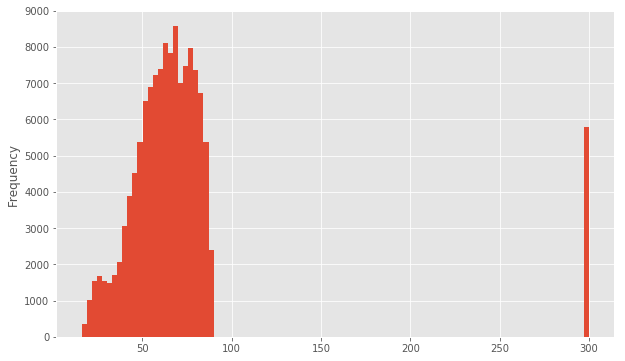

time: 326 ms


In [13]:
len(ABrx_ntnull['icustay_id'].unique())

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
ABrx_16sterile_ntnul['first_admit_age'].sort_values(ascending=True).plot.hist(100)

In [14]:
ABrx_16sterile_ntnul.head()

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,ICU_admit,ICU_disch,los,first_wardid,last_wardid,chartdate,culture_charttime,spec_itemid,spec_type_desc,org_name
0,16,2366833,24915,194424,267059,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
1,842,2366088,24915,194424,267059,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
2,59177,2366064,24915,194424,267059,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
3,59181,2366065,24915,194424,267059,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
4,60474,2367574,24915,194424,267059,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None


time: 24.9 ms


### annotating pt who have antibiotics data in cv, mv, or both. 

In [15]:
# updated 4/11/18  
cv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='carevue']['subject_id'].unique()
mv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='metavision']['subject_id'].unique()

both_pts= []
for pt in ABrx_16sterile_ntnul["subject_id"].unique():
    if pt in cv_pts and pt in mv_pts:
        both_pts.append(pt)
        
#need to annotate in pt_db_association column
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='carevue','pt_ab_db']='cv_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='metavision','pt_ab_db']='mv_ab'
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='both','pt_ab_db']='both_marking_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'subject_id'].isin(both_pts),'pt_ab_db']='cv/mv_ab'


ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul.sort_values('startdate').drop_duplicates('subject_id')
ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul_pts[['subject_id','Antibiotics','dob','gender','first_admit_age','pt_ab_db']]
#pt_ab_age_df = pd.merge(pt_sterile16_list, ABrx_merged_16sterile_ntnul_pts[['subject_id','pt_ab_db']], left_on= 'subject_id', right_on='subject_id',how = 'inner') 

ABrx_16sterile_ntnul_pts['pt_ab_db'].value_counts() #total: 14903

#numbers before regenerating dataset (filtered for only culture dates within icu date windows -> pt has any sterile culture)
# cv_ab              10394 -> 9639 -> 9629
# mv_ab               9993 -> 9243 -> 9228
# cv/mv_ab             777 -> 684 -> 682
# both_marking_ab       72 -> 72 -> 72
# Name: pt_ab_db, dtype: int64

cv_ab              9658
mv_ab              9247
cv/mv_ab            683
both_marking_ab      72
Name: pt_ab_db, dtype: int64

time: 792 ms


### restricting db to only 24hr associated AB and SC
- marking first ab date within 24hr of sterile site culture
- restricting to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
- note: the t_end consec is established in the next set to determine consecutive ab days.

In [16]:
def AB_SC_associated_time_annotation(ABrx_16sterile_ntnul):
    
    """
    fxn: annotates antibiotic dataframe with t_0 and t_end for each patient.
    ##t0 is the first ab date in icu associated within 24 hours of sterile site culture
    ##t_end is the longest duration ab associated with t0
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output: ABrx_16sterile_ntnul annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture. 
    """
    
    #boolean criteria where delta between the AB startdate and culture_charttime is less than 24hr
    lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
        ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'

    #column annotating the delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_16sterile_ntnul['ab_culture_delta'] = (
        pd.to_datetime(ABrx_16sterile_ntnul['startdate']) 
        - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])
    )

    #df of all rows where delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]
    
    #annotating t_0: the first ab date in icu associated within 24 hours of sterile site culture
    ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x))

    
    ABrx_16sterile_ptAB24startdate= ABrx_ab24hrdelta[['icustay_id','t_0']].drop_duplicates('icustay_id')

    ABrx_16sterile_ptAB24enddate= ABrx_ab24hrdelta[
        ABrx_ab24hrdelta['startdate']==ABrx_ab24hrdelta[
            't_0']].sort_values(
                ['subject_id','icustay_id','enddate'], ascending=[True,True,False]).drop_duplicates('icustay_id')


    #adding t_0 and t_end to ABrx_16sterile_ntnul by merging w/ AB24startdate and enddate above
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24startdate,
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24enddate[['icustay_id','enddate']],
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    #renaming columns for ease
    ABrx_16sterile_ntnul=(
        ABrx_16sterile_ntnul.rename(index=str, columns={'enddate_x':'enddate',"enddate_y":"t_end"})
    )
    return(ABrx_16sterile_ntnul)


def AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul):
    
    """
    fxn: restrict the input dataframe to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output: ABrx_16sterile_ntnul annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture and filtered to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    """
    ABrx_16sterile_ntnul = AB_SC_associated_time_annotation(ABrx_16sterile_ntnul)
    
    ABrx_16sterile_ntnul2=(
        ABrx_16sterile_ntnul.loc[
            ABrx_16sterile_ntnul['startdate'] >= ABrx_16sterile_ntnul['t_0']]
    )
    ABrx_16sterile_ntnul2['t_end_consec']=ABrx_16sterile_ntnul2['t_end']
    ABrx_16sterile_ntnul2['abduration']= (
        pd.to_datetime(ABrx_16sterile_ntnul2['enddate'])
        - pd.to_datetime(ABrx_16sterile_ntnul2['startdate'])
    )

    ABrx_16sterile_ntnul2.sort_values(['subject_id','startdate'])
    return(ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2) #this should be df where all ab_icustart dates are greater than or 
                                  #equal to the first 24 hour associated ab start date after icu admission.

time: 65 ms


In [17]:
ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2= AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

time: 4.08 s


In [18]:
###Algorithm to squash all dates into a timespan that covers the continuous days on any AB starting at the first ab within 24 hour of a sc
@memory.cache
def update_t_end(t):  
    t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'t_end_consec']= t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'enddate']
    t['t_end_consec']= t.groupby('icustay_id')['t_end_consec'].transform(lambda x: max(x))
    t['abduration']= pd.to_datetime(t['t_end_consec'])-pd.to_datetime(t['t_0'])
    return(t)


time: 7.95 ms


### Calculate and annotate the total continuous time on ANY antibiotic during each patient’s icu stay

In [19]:
def t_end_consec_annotation(ABrx_16sterile_ntnul2):
    """
    input: df, 
    designed for ABrx_16sterile_ntnul2-this should be df where all ab_icustart dates are greater than or equal to the first 24 hour associated ab start date after icu admission.

    output: ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT: the former being all ab's that 
    """
        
    important_columns=[
        'subject_id','icustay_id','drug',
        'culture_charttime','ab_culture_delta','startdate',
        'enddate','t_0','t_end',
        'abduration','t_end_consec','ICU_admit','ICU_disch'
    ]
    ABrx_16sterile_ntnul_final= ABrx_16sterile_ntnul2[important_columns].sort_values(
        ['subject_id',
         'icustay_id',
         'startdate',
         'abduration'], ascending=[True, True, False, True])
    
    #updating t_end consec by running my update_t_end algorithm 5 times. 
    i=1
    while i<6:
        ABrx_16sterile_ntnul_final= update_t_end(ABrx_16sterile_ntnul_final)
        i+=1
    
    #making a final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_final.sort_values(
        ['subject_id','startdate'], ascending=[True,True]).drop_duplicates('subject_id')

    return(ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT)


time: 12.8 ms


In [20]:
ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT= t_end_consec_annotation(ABrx_16sterile_ntnul2)

time: 36.9 s


count                     12801
mean     5 days 10:32:45.783923
std      5 days 22:47:00.590484
min             0 days 00:00:00
25%             2 days 00:00:00
50%             4 days 00:00:00
75%             7 days 00:00:00
max            97 days 00:00:00
Name: abduration, dtype: object
2 days    1809
1 days    1718
3 days    1654
4 days    1218
5 days    1032
0 days     937
6 days     884
7 days     676
Name: abduration, dtype: int64
(7 days 21:51:50.399999, 97 days 00:00:00]    2873
Name: abduration, dtype: int64


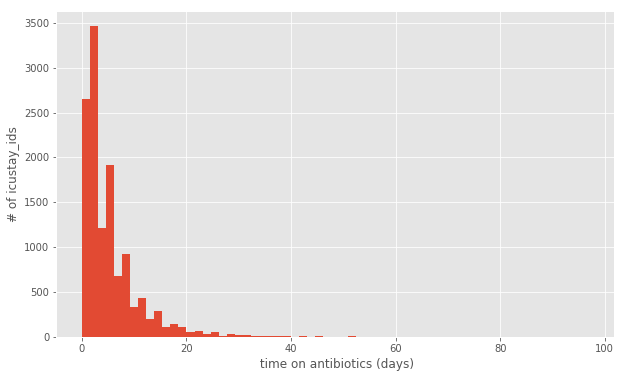

time: 290 ms


In [21]:
#all patients with appropriate antibiotic timing in relation to sterile culture. 
print(ABrx_16sterile_ntnul_finalPT['abduration'].describe())

(ABrx_16sterile_ntnul_finalPT['abduration'] / pd.Timedelta(days=1)).hist(bins = 63)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' time on antibiotics (days)')
plt.ylabel('# of icustay_ids');

print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))
#4/24: n=12613. 
#7/6/18: n=12611

# adding in DOD
we realized later on that we need dod in our spreadsheet. below adds it to our final patient set. 

In [22]:
#task 3, dod
#issue: there is a differential on 155 ssd's. 

#(DOD_HOSP) or the social security database (DOD_SSN).


list_pt =ABrx_16sterile_ntnul_finalPT['subject_id'].unique()
dod_sql = query_schema + """
SELECT subject_id, DOD_HOSP, DOD_SSN 
from mimiciii.patients
WHERE subject_id in {}
""".format(tuple(list_pt))     
dod_df = pd.read_sql_query(dod_sql,conn)

dod_df['delta']= dod_df['dod_hosp']- dod_df['dod_ssn']
#dod_df.loc[dod_df.loc[:,'delta'].notnull()!=timedelta(days=0),:]

dod_df2= dod_df[dod_df['delta'].notnull()]
dod_df2.loc[dod_df2.loc[:,'delta']!= timedelta(days=0),:]

,subject_id,dod_hosp,dod_ssn,delta
224,1339,2140-02-27,2140-02-28,-1 days
280,1748,2188-07-20,2188-07-18,2 days
288,1787,2117-01-14,2117-01-16,-2 days
378,2228,2187-06-20,2187-06-21,-1 days
395,2349,2165-05-16,2165-05-28,-12 days
423,2570,2115-02-20,2115-02-21,-1 days
470,2809,2131-11-23,2131-11-13,10 days
673,3913,2132-08-19,2132-08-27,-8 days
676,3920,2113-01-30,2113-01-27,3 days
751,4276,2109-09-18,2109-09-15,3 days


time: 132 ms


In [23]:
# categorize pt into ab bins

time: 626 µs


In [24]:
#task 4, categorize every patient into ab bins
# group 1= partial= is antibiotics for 3 days or less
# group 2= full= is antibiotics for 5 or more days or died during ab course

ABrx_16sterile_ntnul_finalPT = pd.merge(
    ABrx_16sterile_ntnul_finalPT,
    dod_df[['subject_id','dod_hosp','dod_ssn']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

ABrx_16sterile_ntnul_finalPT['ab_course']=''

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] <= pd.Timedelta(days=4),'ab_course']='partial' #days changed from 3 to 4 on 7/16/18 based on Nelson's suggestion

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] >= pd.Timedelta(days=5),'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_hosp'])),
    'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_ssn'])),
    'ab_course']='full'

print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='full','subject_id'].unique())) #5485 full patients -> 6188 full on 7/6
print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='partial','subject_id'].unique())) #5949 partial patients -> 5305 partial on 7/6


6479
6322
time: 65.4 ms


In [25]:
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']>= pd.Timedelta(days=8),'abduration'].value_counts(bins=1))

2 days    1809
1 days    1718
3 days    1654
4 days    1218
5 days    1032
0 days     937
6 days     884
7 days     676
Name: abduration, dtype: int64
(7 days 21:51:50.399999, 97 days 00:00:00]    2873
Name: abduration, dtype: int64
time: 13.1 ms


In [26]:
ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']== pd.Timedelta(days=0),:]

,subject_id,icustay_id,drug,culture_charttime,ab_culture_delta,startdate,enddate,t_0,t_end,abduration,t_end_consec,ICU_admit,ICU_disch,dod_hosp,dod_ssn,ab_course
15,106,252051,Nafcillin,2192-08-15 03:46:00,-1 days +20:14:00,2192-08-15,2192-08-15,2192-08-15,2192-08-15,0 days,2192-08-15,2192-08-09 18:35:44,2192-08-15 22:33:57,2192-08-15,2192-08-15,full
17,111,249202,Vancomycin,2144-07-01 03:05:00,-1 days +20:55:00,2144-07-01,2144-07-01,2144-07-01,2144-07-01,0 days,2144-07-01,2144-07-01 04:13:59,2144-07-01 17:56:31,2144-07-01,NaT,full
22,129,238431,CeftriaXONE,2157-03-27 10:27:00,-1 days +13:33:00,2157-03-27,2157-03-27,2157-03-27,2157-03-27,0 days,2157-03-27,2157-03-27 08:46:58,2157-03-28 17:53:35,NaT,NaT,partial
29,166,271863,Levofloxacin,2105-01-23 00:00:00,1 days 00:00:00,2105-01-24,2105-01-24,2105-01-24,2105-01-24,0 days,2105-01-24,2105-01-23 23:00:10,2105-01-24 05:39:49,2105-01-24,2105-01-24,full
44,228,235332,Levofloxacin,2132-11-01 07:30:00,-1 days +16:30:00,2132-11-01,2132-11-01,2132-11-01,2132-11-01,0 days,2132-11-01,2132-10-31 16:53:04,2132-11-06 18:53:16,NaT,2137-12-29,partial
51,266,293876,Ampicillin-Sulbactam,2168-07-12 02:27:00,-1 days +21:33:00,2168-07-12,2168-07-12,2168-07-12,2168-07-12,0 days,2168-07-12,2168-07-10 08:02:23,2168-07-11 17:40:38,NaT,NaT,partial
89,430,281104,Levofloxacin,2155-09-16 07:57:00,-1 days +16:03:00,2155-09-16,2155-09-16,2155-09-16,2155-09-16,0 days,2155-09-16,2155-09-16 00:15:02,2155-09-16 13:04:10,2155-09-16,2155-09-16,full
120,631,211592,MetRONIDAZOLE (FLagyl),2124-01-15 00:23:00,-1 days +23:37:00,2124-01-15,2124-01-15,2124-01-15,2124-01-15,0 days,2124-01-15,2124-01-13 23:03:32,2124-01-15 22:47:38,NaT,2124-07-18,partial
129,705,286061,Clindamycin,2156-08-23 11:48:00,-1 days +12:12:00,2156-08-23,2156-08-23,2156-08-23,2156-08-23,0 days,2156-08-23,2156-08-23 00:44:29,2156-08-26 14:22:45,2156-08-26,2156-08-26,partial
132,712,255571,Sulfameth/Trimethoprim DS,2155-11-02 05:24:00,-1 days +18:36:00,2155-11-02,2155-11-02,2155-11-02,2155-11-02,0 days,2155-11-02,2155-11-01 23:32:33,2155-11-02 22:07:09,2159-08-28,2159-08-28,partial


time: 52.4 ms


In [27]:
ABrx_16sterile_ntnul_finalPT['icustay_id'].nunique() #12611 subject id's, 12611 icustay id's

12801

time: 6.6 ms


# Extracting Sterile Site Culture results
### accounting for all sterile cultures taken within 48 hours of the first ab. 
4/22/18

In [28]:
#big question to answer, all sterile cultures within 48 hours of what? i am going to set timeframe for each patient: 
#look at all cultures between the first SC within 24 hour of ab and up to 48 hours after first ab dose in ICU.
#this means the max i will cover is 72 hours. 

time: 610 µs


In [29]:
#1) first define the 24 hour associated ab- t_0_sc
#2) define 48 hour after the ab- t_end_sc
#filter list of all sterile cultures on the above icustay_id and dates
#record for each icustay_id if any of cultures within the timeframe are positive


def pt_sc_results(ABrx_16sterile_ntnul):

    lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
        ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'
    ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]

    ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x))


    ABrx_ab24hrdelta['t_0_sc']= ABrx_ab24hrdelta.groupby('icustay_id')['culture_charttime'].transform(lambda x: min(x))
    ABrx_ab24hrdelta['t_end_sc']= pd.to_datetime(ABrx_ab24hrdelta['t_0']) + timedelta(days=2)

    #filtering it to only essential info, and only for patients who made it through all other criteria. 
    patients_sc_dates= ABrx_ab24hrdelta[['subject_id','icustay_id','hadm_id','t_0_sc','t_end_sc']].drop_duplicates('icustay_id')
    
    #filtering to only pt in ABrx_16sterile_ntnul_finalPT
    patients_sc_dates= patients_sc_dates.loc[
        patients_sc_dates.loc[:,'icustay_id'].isin(
            list(ABrx_16sterile_ntnul_finalPT['icustay_id'].unique())),:
    ] 
    
    final_pts_all_sc= sterile_pt_df.loc[sterile_pt_df.loc[:,'hadm_id'].isin(list(patients_sc_dates['hadm_id'].unique())),:] 
    final_pts_all_sc= pd.merge(final_pts_all_sc,patients_sc_dates[['hadm_id','t_0_sc','t_end_sc']], left_on= 'hadm_id', right_on='hadm_id', how = 'inner')

    pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])

    #all sterile site culture instances between t_0_sc and t_end_sc for patients     
    final_pts_window_sc= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                    (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                    final_pts_all_sc['org_name'].notnull()] 


    positive_organisms= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
                    (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
                    final_pts_all_sc['org_name'].notnull()]['org_name'].value_counts()
    
    return(patients_sc_dates, final_pts_window_sc, positive_organisms)

time: 42.8 ms


In [30]:
patients_sc_dates, final_pts_window_sc, positive_organisms = pt_sc_results(ABrx_16sterile_ntnul)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


time: 6.22 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# SC culture filtering and ab death dose adjust

###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.




In [31]:
#all sterile site culture instances between t_0_sc and t_end_sc for patients annotated.
#need further processing to make a by patient +/- within t_0_sc and t_end_sc call. 
##details: all staph infections require 2 positive cultures in time window. 
annotated_sc = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/positive_organisms_4-24-18_NSPComments.csv')
#organisms that grew in sc in our patients. annotation key:
#1= eliminate
#0= keep
#2= requires 2 positives in same patient within the timewindow. 
final_pts_window_sc= pd.merge(final_pts_window_sc,annotated_sc[['org_name','Eliminate']], left_on= 'org_name', right_on='org_name', how = 'left')



time: 17.5 ms


In [32]:
def sc_pos_filter(final_pts_window_sc):
    final_pts_window_sc2= final_pts_window_sc.loc[final_pts_window_sc.loc[:,'Eliminate']==2,:]
    #this is how i should do things according to style guide
    final_pts_window_sc2['concat_col']=(
        final_pts_window_sc2['subject_id'].map(str) 
        + ' ' 
        + final_pts_window_sc2['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc2['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc2.drop_duplicates('concat_col') #n=1603

    test=0
    test = pd.DataFrame(final_pts_window_sc3['subject_id'].value_counts().reset_index())
    test.columns = ['subject_id', 'staph_pos_count']

    merged = pd.merge(
        final_pts_window_sc,
        test[['subject_id','staph_pos_count']],
        left_on= 'subject_id',
        right_on='subject_id',
        how = 'left')

    t1= merged.loc[:,'Eliminate']==0
    t2= merged.loc[:,'staph_pos_count']>1
    merged= merged[t1|t2]
    merged= merged[merged['Eliminate']!=1]
    return(merged)

final_pts_window_pos_sc = sc_pos_filter(final_pts_window_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
#len(final_pts_window_pos_sc_list) #2630. 

time: 98.4 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# FINAL cohort generation
1) make list of all patients positive, negative sc cultures

2) clean up sc code and qc. 

3) import DOD

4) make final ab categorizations
 
5) make final patient list with ab, sterile site culture results and final binning

In [33]:
#5/2/18, makes list of all pos culture result and specimen types for final df at nelson's request
def sc_pos_filter2(final_pts_window_sc):
    final_pts_window_sc['concat_col']=(
        final_pts_window_sc['subject_id'].map(str) 
        + ' ' 
        + final_pts_window_sc['org_name'].map(str) 
        + ' ' 
        +  final_pts_window_sc['chartdate'].map(str)
    )
    final_pts_window_sc3= final_pts_window_sc.drop_duplicates('concat_col') #n=1603

    return(final_pts_window_sc3)

final_pts_window_pos_sc2 = sc_pos_filter2(final_pts_window_pos_sc) #31108 #all sc for patients with any positives.
final_pts_window_pos_sc3 = final_pts_window_pos_sc2.groupby('subject_id')['org_name'].apply(', '.join).reset_index()
final_pts_window_pos_sc3 = final_pts_window_pos_sc3.rename(index=str, columns={'org_name':'org_list'})

final_pts_window_pos_sc4 = final_pts_window_pos_sc2.groupby('subject_id')['spec_type_desc'].apply(', '.join).reset_index()
final_pts_window_pos_sc4 = final_pts_window_pos_sc4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

#now have a column with all positive culture results and specimen types


time: 484 ms


In [34]:
#4/30/18: ASSEMBLING A FINAL PT LIST. 
final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
#patients_sc_dates=patients_sc_dates.drop('ab_duration', axis=1)
final_pt_df = patients_sc_dates


final_pt_df = pd.merge(
    final_pt_df,
    ABrx_16sterile_ntnul_finalPT[['icustay_id','ab_course', 't_0','t_end_consec','ICU_admit']], #testing the ICU_admit with this
    left_on= 'icustay_id', #changed from subject_id
    right_on='icustay_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    dod_df2,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc3,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    final_pts_window_pos_sc4,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod_delta'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'subject_id'].isin(final_pts_window_pos_sc_list),'sc_result']='positive'
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

#len(list(final_pts_window_pos_sc['subject_id'].unique())) #2630

final_pt_df
final_pt_df2= final_pt_df.loc[final_pt_df.loc[:,'ab_course']!='',:] 
#this is final patient dataframe with 11434 patients with following criteria:
#antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
#who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
#also annotated on this. these patients were then categorized into 4 categories:
# 'C_neg/A_partial'
# 'C_neg/A_full'
# 'C_pos/A_full'
# 'C_pos/A_partial'
# notes:
# 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

# 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 


#pd.DataFrame(final_pt_df2).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/06072018_final_pt_df2.csv')


time: 180 ms


In [35]:
final_pt_df2['subject_id'].nunique()

12801

time: 3.53 ms


In [36]:
print(final_pt_df2['final_bin'].value_counts())#11493

C_neg/A_partial    5118
C_neg/A_full       4776
C_pos/A_full       1703
C_pos/A_partial    1204
Name: final_bin, dtype: int64
time: 3.48 ms


# cohort generated above

dr luo request:

It would also be good to add the start and end time for the antibiotics. --DONE


Dr. Nelson request:

 1)provide an extra column with the DOD. --DONE
 
 2)one with the first positive culture results (the actual value, as in “Enteroccous Faecalis”, etc.) for those with positive cultures, 
 
 3)the type of culture (eg. urine, blood, etc.).

In [37]:
# #5/15/18 to do, regenerate this for our cohort to get count of sterile site cultures. 
# #breakdown the 1345 pts cultures, 
# #if a patient has multiple culture types within 24 hr peroid, would be nice to know which are +/-. 
# #more informative to know if pt was ever pos for bloodculture.

# #Look at distribution of all cultures within the 24 hour mark. 

# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# sterile_test_df.spec_type_desc.value_counts().head(20).sort_values(ascending=True).plot.barh()

time: 1.47 ms


# compiling the dataframes into csv's

In [38]:
date='16072018'


pd.DataFrame(final_pt_df2).to_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv" %date) #final cohort database n=11493 subject_id’s (7/6/18)
#this is final patient dataframe with 11434 patients with following criteria:
#antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
#who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
#also annotated on this. these patients were then categorized into 4 categories:
# 'C_neg/A_partial'
# 'C_neg/A_full'
# 'C_pos/A_full'
# 'C_pos/A_partial'


#pd.DataFrame(ABrx_16sterile_ntnul).to_csv('%s_ABrx_16sterile_ntnul.csv' %date) #all prescription table rows and pts.
#pd.DataFrame(final_pts_all_sc).to_csv('%s_final_pts_all_sc.csv' %date) #all sterile culture, and hospital/icu info
#pd.DataFrame(ABDB).to_csv('%s_ABdb.csv' %date) #all sterile culture, and hospital/icu info



#pd.DataFrame(ABrx_16sterile_ntnul).to_csv('ABrx_16sterile_ntnul_%s.csv' %date)
#pd.DataFrame(ABrx_16sterile_ntnul_pts).to_csv('ABrx_16sterile_ntnul_pts_%s.csv' %date)


time: 173 ms


In [39]:
# date='04-26-18'

# pd.DataFrame(final_events_df).to_csv("final_events_df_%s.csv" %date)

time: 706 µs


issue to resolve:
    
    Although there are more antibiotic item id's linked to CV, we recruited more AB patients from MV. 
    
    we may have duplicated ab info for patients in both databases

style guide stuff:
    
79 characters is longest a line should be, this is 79 chars:
Address the unique rows issue in the sterile culture. Need to use this to filkter down the staph.

In [40]:
#last instance of ICU_admit time. 

time: 440 µs


In [41]:
#final_pt_df2

time: 497 µs


In [42]:
(pd.to_datetime(final_pt_df2['ICU_admit'])-pd.to_datetime(final_pt_df2['t_0'])).describe()

count                       12801
mean     -1 days +09:05:02.982188
std        2 days 07:37:10.262975
min            -77 days +13:52:53
25%             -1 days +14:24:33
50%             -1 days +20:39:11
75%               0 days 01:53:45
max               0 days 11:59:39
dtype: object

time: 14.2 ms


In [43]:
final_pt_df2['admit_vs_t_0']= (pd.to_datetime(final_pt_df2['ICU_admit'])-pd.to_datetime(final_pt_df2['t_0']))

time: 6.8 ms


In [44]:
final_pt_df2['admit_vs_t_0_td']=final_pt_df2['admit_vs_t_0'].astype(np.timedelta64)

time: 1.64 ms


In [45]:
final_pt_df2.sort_values('admit_vs_t_0_td')

final_pt_df2[final_pt_df2['admit_vs_t_0_td']<-1e+14].sort_values('admit_vs_t_0_td')['subject_id'].nunique() #3519/11488 patients have a delta of greater than 2 days of their icustay



1879

time: 11.3 ms
